### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [2]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np
from itertools import combinations
import os
import datetime
import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.0

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

170508288/170498071 [==============================] - 3s 0us/step


In [5]:
img_height, img_width, channel

(32, 32, 3)

In [6]:
# convert to one hot encoding 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train, X_test = X_train / 255.0, X_test / 255.0

In [8]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

In [9]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

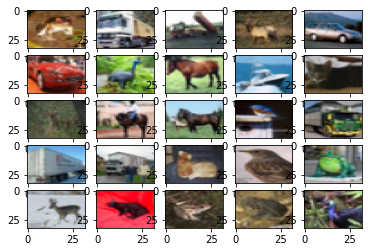

In [10]:
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(X_train[k], aspect='auto')
        k += 1
 
plt.show()

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
#https://neptune.ai/blog/data-augmentation-in-python
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    #zoom_range=[0.8,1.2],
    width_shift_range=0.17 ,
    height_shift_range=0.17,
    #shear_range=0.15,
    horizontal_flip=True
    #fill_mode="nearest"
    )

#datagen.fit(X_train)

In [13]:
#Referene Notebook

# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [14]:
num_filter = 32
dropout_rate = 0.0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

2022-02-19 12:00:41.237363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 12:00:41.333559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 12:00:41.334405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 12:00:41.335622: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
import keras.backend as K
class RateHistory(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = float(K.get_value(self.model.optimizer.lr))
        print('\nEpoch %05d: Learning rate to %s.' % (epoch + 1, lr))  
        
rate_own=RateHistory()        

In [17]:
def changeLearningRate(epoch,lr):
    lr = 0.01
    if epoch > 50:
        lr = 0.001
    return lr

In [18]:
from tensorflow.keras.optimizers import SGD

lrschedule = tf.keras.callbacks.LearningRateScheduler(changeLearningRate)

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
#                              patience=5,verbose=1,mode="auto",min_delta=0.01,min_lr=0.001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) #SGD(learning_rate=0.1, decay=1e-4, momentum=0.9 ,nesterov=True ) 

#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3, verbose=1)

filepath= "best_model_L1.h5" #"model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

2022-02-19 12:00:45.032642: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-19 12:00:45.032689: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-19 12:00:45.034441: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-02-19 12:00:45.248704: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-19 12:00:45.248901: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [19]:
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

model.fit(datagen.flow(X_train, y_train, batch_size=128),
         steps_per_epoch=len(X_train) / 128, epochs= 70 ,validation_data=(X_test, y_test),callbacks=[lrschedule,rate_own,checkpoint,tensorboard_callback])

2022-02-19 12:00:45.705648: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70

Epoch 00001: Learning rate to 0.009999999776482582.


2022-02-19 12:00:50.825956: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/390 [..............................] - ETA: 1:15:51 - loss: 2.4849 - accuracy: 0.1016

2022-02-19 12:00:57.553110: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-19 12:00:57.553180: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/390 [..............................] - ETA: 3:39 - loss: 3.4121 - accuracy: 0.1211   

2022-02-19 12:00:57.985628: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-19 12:00:57.987336: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-02-19 12:00:58.170448: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1343 callback api events and 1340 activity events. 
2022-02-19 12:00:58.249045: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-19 12:00:58.339446: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fits/20220219-120045/train/plugins/profile/2022_02_19_12_00_58

2022-02-19 12:00:58.375655: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fits/20220219-120045/train/plugins/profile/2022_02_19_12_00_58/eddd056db730.trace.json.gz


  3/390 [..............................] - ETA: 4:03 - loss: 3.6261 - accuracy: 0.1042

2022-02-19 12:00:58.496587: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fits/20220219-120045/train/plugins/profile/2022_02_19_12_00_58

2022-02-19 12:00:58.507059: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/fits/20220219-120045/train/plugins/profile/2022_02_19_12_00_58/eddd056db730.memory_profile.json.gz
2022-02-19 12:00:58.512105: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/fits/20220219-120045/train/plugins/profile/2022_02_19_12_00_58
Dumped tool data for xplane.pb to logs/fits/20220219-120045/train/plugins/profile/2022_02_19_12_00_58/eddd056db730.xplane.pb
Dumped tool data for overview_page.pb to logs/fits/20220219-120045/train/plugins/profile/2022_02_19_12_00_58/eddd056db730.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/fits/20220219-120045/train/plugins/profile/2022_02_19_12_00_58/eddd056db730.input_pipelin

390/390 [==============================] - 66s 139ms/step - loss: 2.0131 - accuracy: 0.2742 - val_loss: 2.2075 - val_accuracy: 0.2193

Epoch 00001: val_accuracy improved from -inf to 0.21930, saving model to best_model_L1.h5
Epoch 2/70

Epoch 00002: Learning rate to 0.009999999776482582.
390/390 [==============================] - 51s 129ms/step - loss: 1.6326 - accuracy: 0.4000 - val_loss: 1.9691 - val_accuracy: 0.3498

Epoch 00002: val_accuracy improved from 0.21930 to 0.34980, saving model to best_model_L1.h5
Epoch 3/70

Epoch 00003: Learning rate to 0.009999999776482582.
390/390 [==============================] - 50s 129ms/step - loss: 1.3937 - accuracy: 0.4926 - val_loss: 2.4285 - val_accuracy: 0.3579

Epoch 00003: val_accuracy improved from 0.34980 to 0.35790, saving model to best_model_L1.h5
Epoch 4/70

Epoch 00004: Learning rate to 0.009999999776482582.
390/390 [==============================] - 49s 125ms/step - loss: 1.1962 - accuracy: 0.5690 - val_loss: 1.2150 - val_accuracy: 

In [21]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 4s 11ms/step - loss: 0.3606 - accuracy: 0.9005
Test loss: 0.36061739921569824
Test accuracy: 0.9004999995231628


In [22]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk
